In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


#Задача бинарной классификации
#Программа должна научиться предугадывать, будет пассажир доволен полетом на самолете или нет, основываясь на опросе о качестве обслуживания
#Проведем разведочный анализ данных
#Для начала взглянем на структуру
df = pd.read_csv('train.csv') 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [39]:
#Видно, что колонка "Unnamed" - идентификатор, от которого можно избавиться
df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

In [40]:
#Проверим, в каких ячейках и каком количетсве содержатся пустые данные
df.isnull().sum() 

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [41]:
#Проверим фрейм на наличие дубликатов
df.duplicated().sum()

np.int64(0)

In [42]:
#Выводы о наборе данных:
#DataFrame состоит из 24 признаков и 103904 моделей, вклчая id, данные о пассажире и оценки качества полета
#Признаки 'Gender', 'Customer Type', 'Type of Travel', 'Class', и 'satisfaction' являются категориальными, то есть их можно интерпретировать как объект
#Остальные признаки являются числовыми
#В большинстве переменых оценивается качество полета по различным параметрам, оценка происходит в целых числах
#'satisfaction' - целевая переменная
#Есть 310 моделей, где признак "Arrival Delay in Minutes" не заполнен
#Дубликаты отсутствуют

In [58]:
#Функция для визуализации распределения данных в процентах
def plot_percent_data(df, column):
    counts = df[column].value_counts()
    percentages = (counts / counts.sum()) * 100
    data = pd.DataFrame({'Percentage': percentages})
    plt.figure(figsize=(10, 6))
    data['Percentage'].plot(kind='bar')
    plt.title(f'Процентное распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Процентное соотношение (%)')
    plt.show()


#Функция для визуализации распределения данных в числах
def plot_numerical_data(df, column):
    plt.figure(figsize=(10, 6))
    df[column].hist(bins=30)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

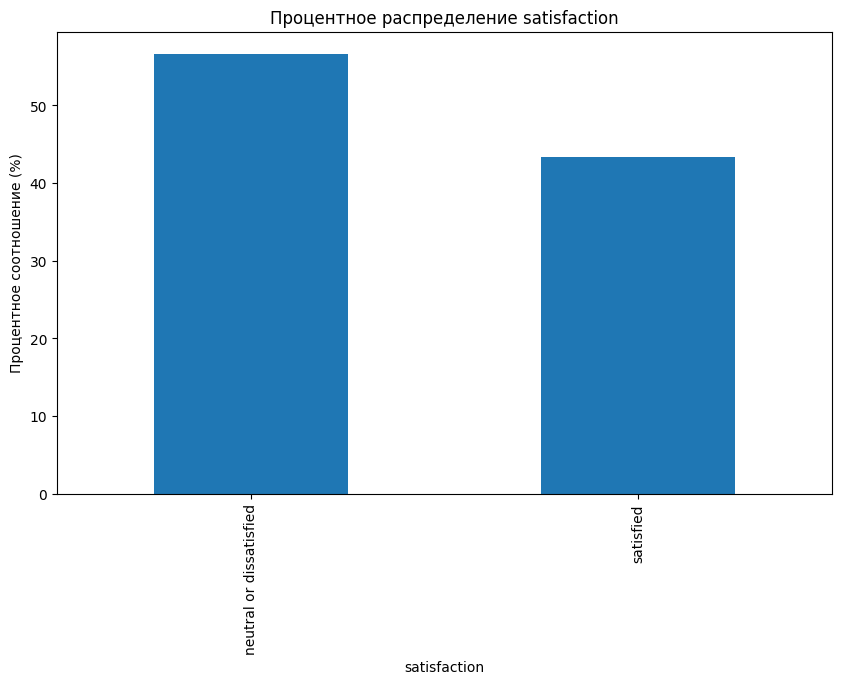

In [59]:
#Посмотрим на распределение целевой переменной
plot_percent_data(df, 'satisfaction')

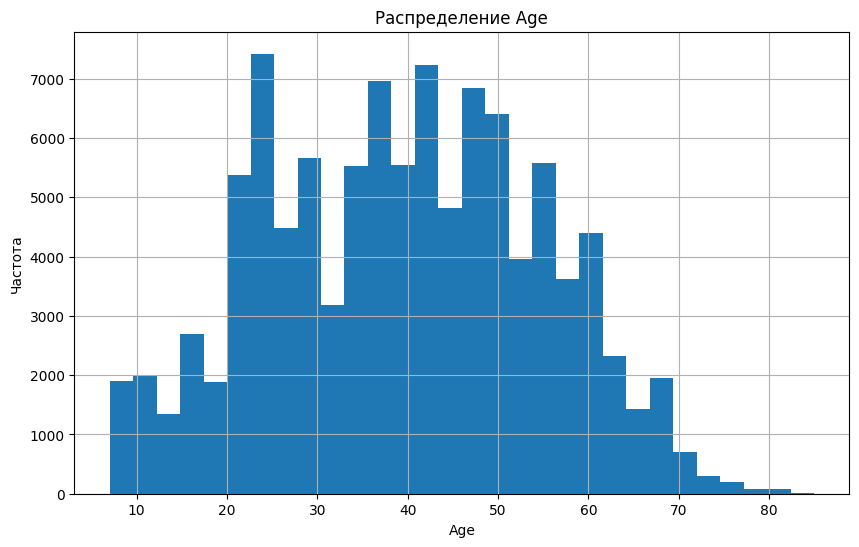

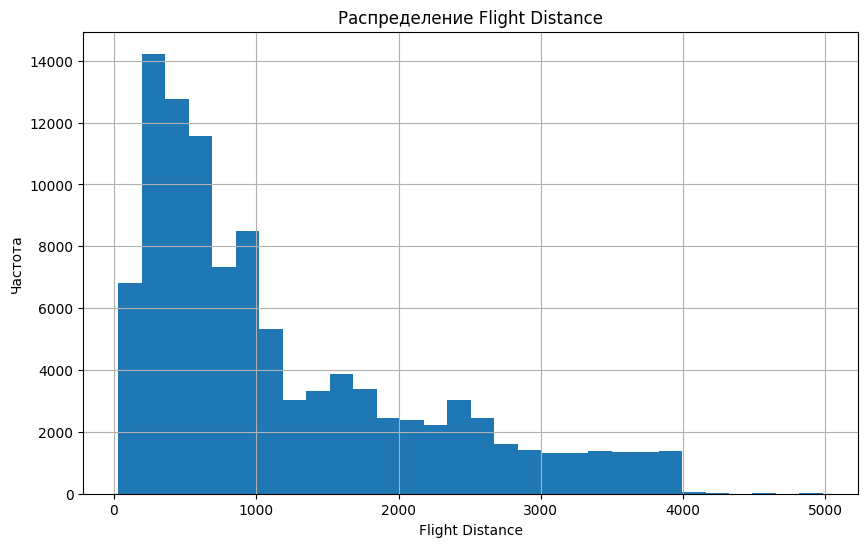

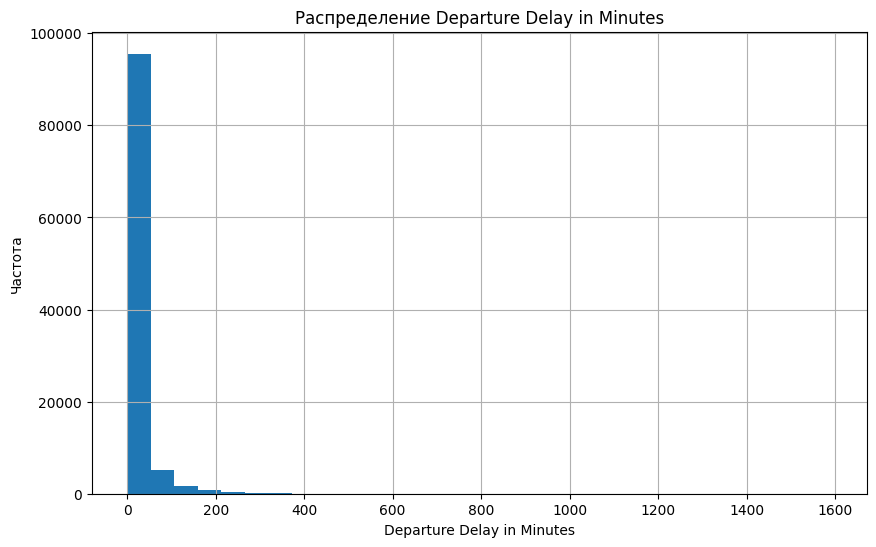

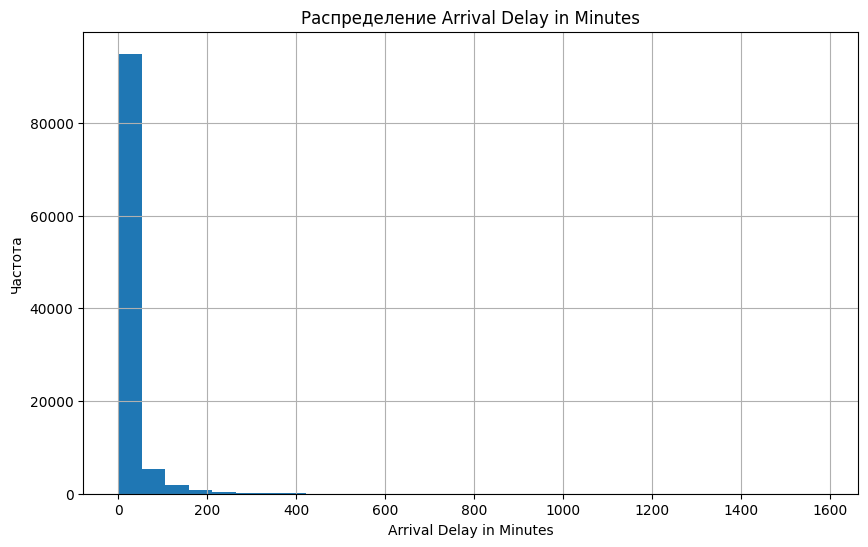

In [45]:
#Посмотрим на распределение числовых данных (помимо оценок полета)

#Возраст
plot_numerical_data(df, 'Age')

#Дальность полета
plot_numerical_data(df, 'Flight Distance')

#Задержка вылета и задержка прибытия
plot_numerical_data(df, 'Departure Delay in Minutes')
plot_numerical_data(df, 'Arrival Delay in Minutes')

In [46]:
#Выводы о числовых данных и целевой переменной:
#Большинство пассажиров недовольно качеством обслуживания
#Более 2000 пассажиров находятся в возрасте от 23 до 27 лет и от 35 до 45 лет
#Более 4000 пассажиров путешествуют на расстояние около 800 километров
#Максимальная задержка вылета и прибытия составляет примерно от 0 до 10 минут
#Можно сказать, что в большинстве случаев задержек нет

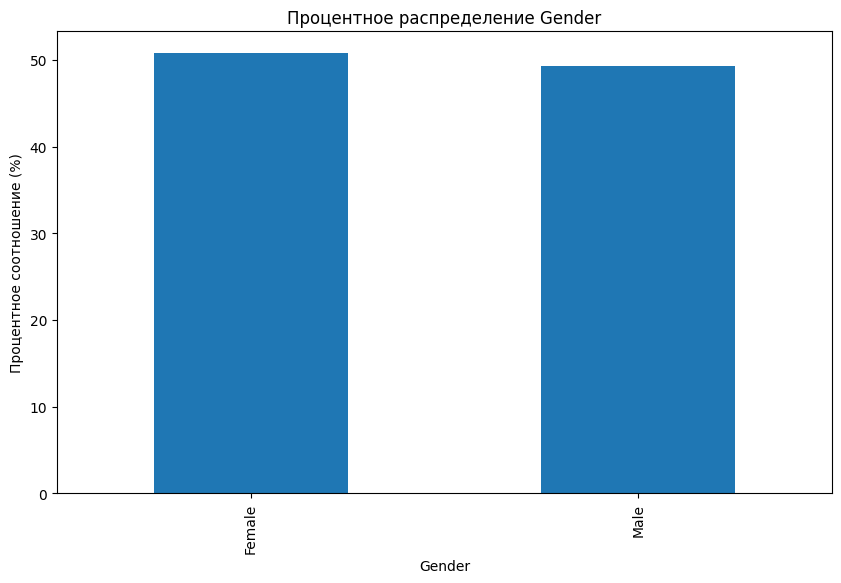

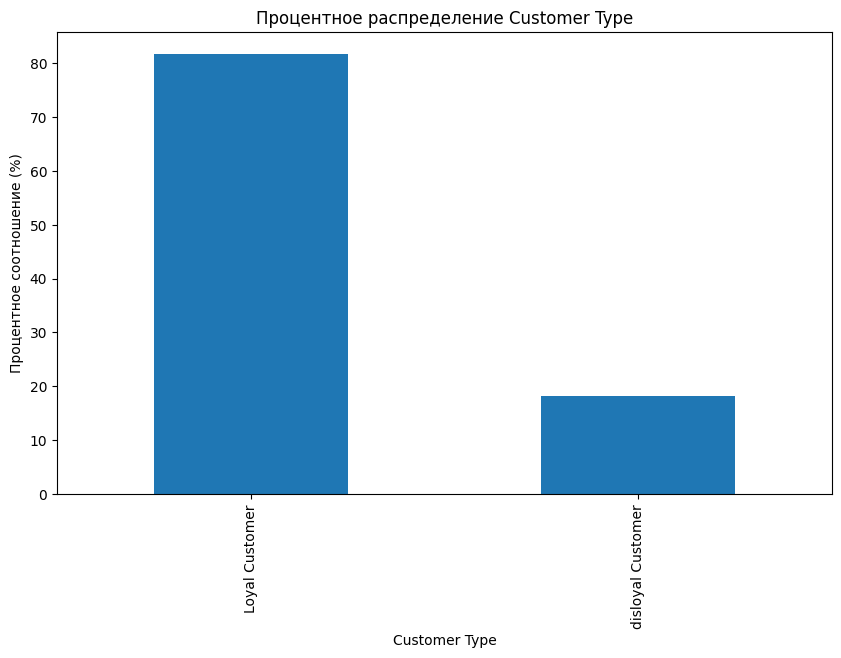

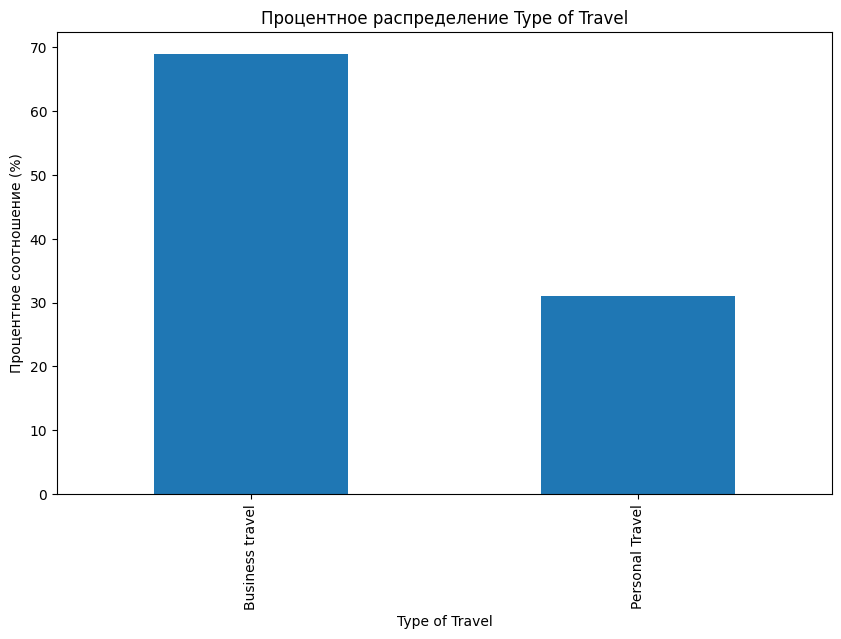

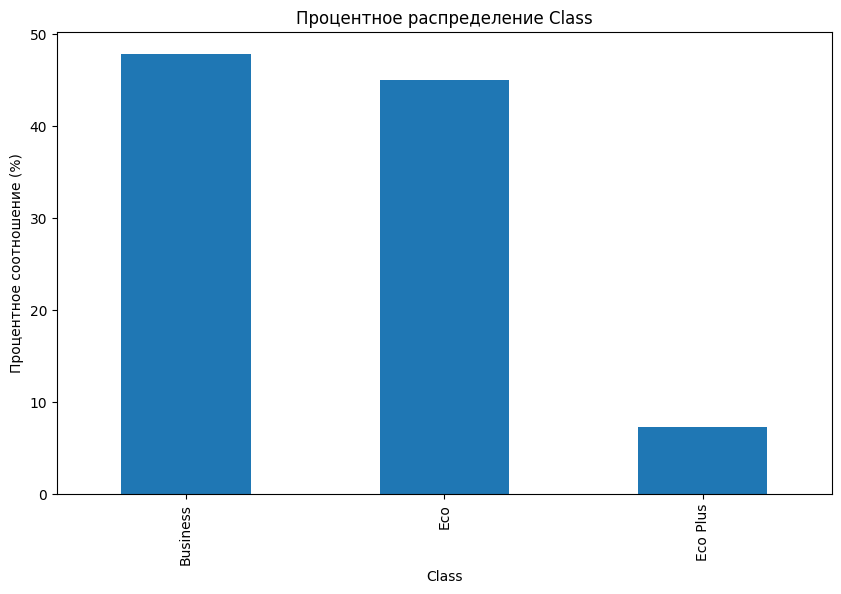

In [60]:
#Посмотрим на распределение категориальных данных

#Пол
plot_percent_data(df, 'Gender')

#Лояльные и нелояльные клиенты
plot_percent_data(df, 'Customer Type')

#Цель поездки
plot_percent_data(df, 'Type of Travel')

#Класс полета
plot_percent_data(df, 'Class')

In [48]:
#Выводы о категориальных данных:
#Женщин пассадиров немного больше, чем мужчин
#Доля лояльных пассажиров около 80%
#Почти у 70% пассажиров деловая цель поездки
#Более 80% пассажиров путешествуют бизнес и эконом-классом

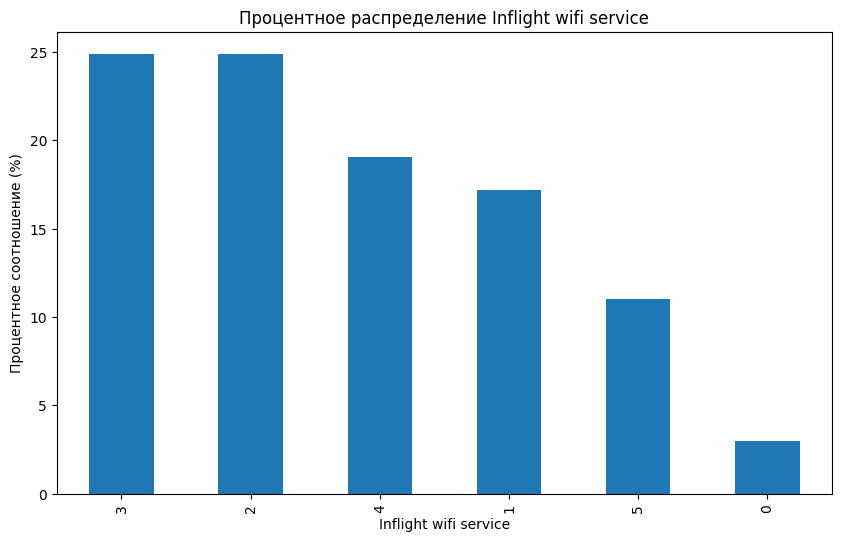

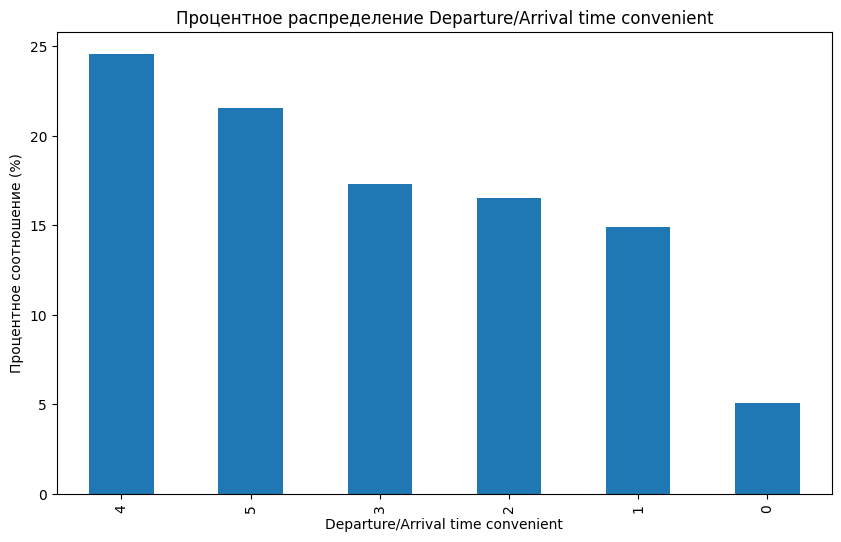

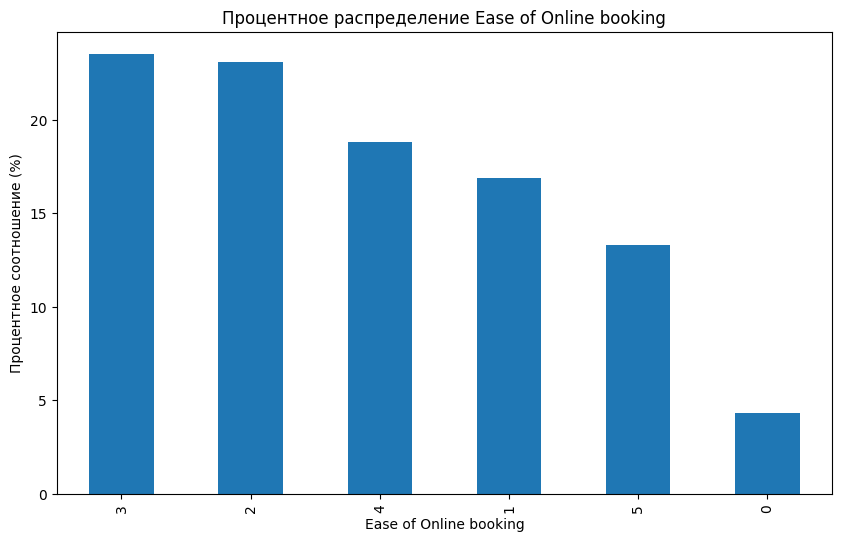

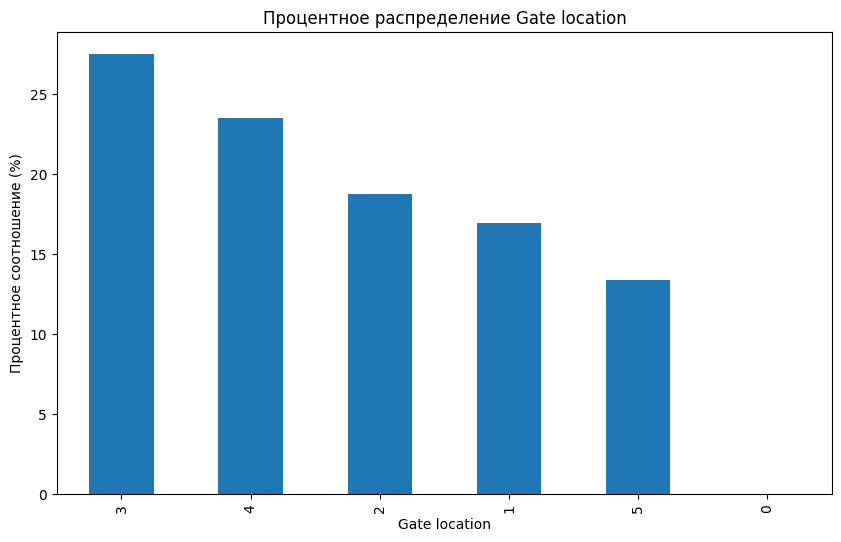

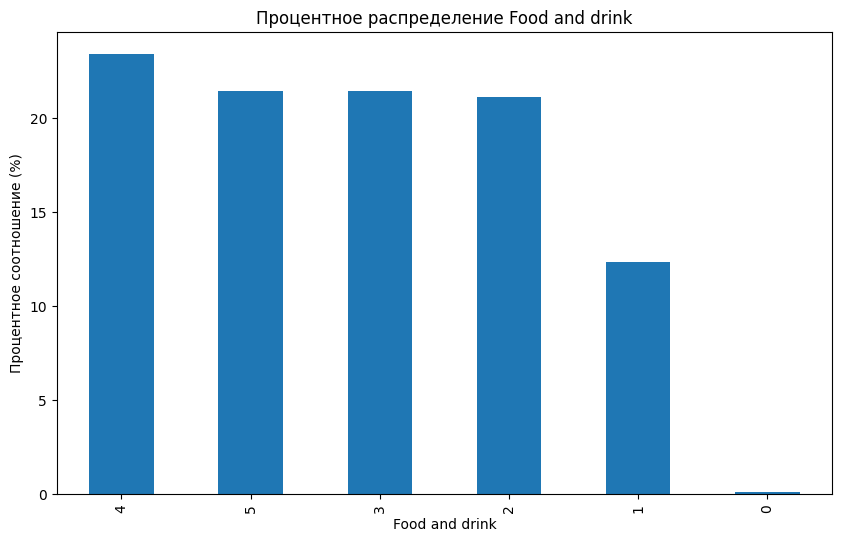

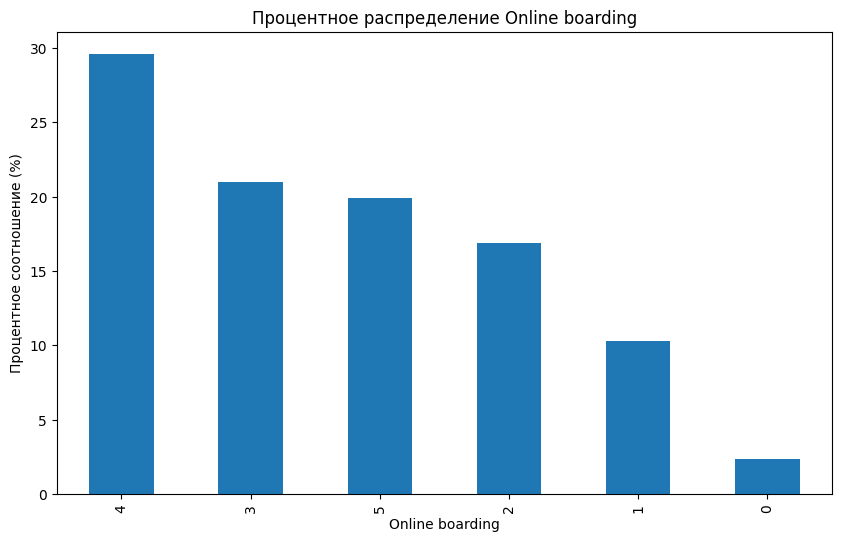

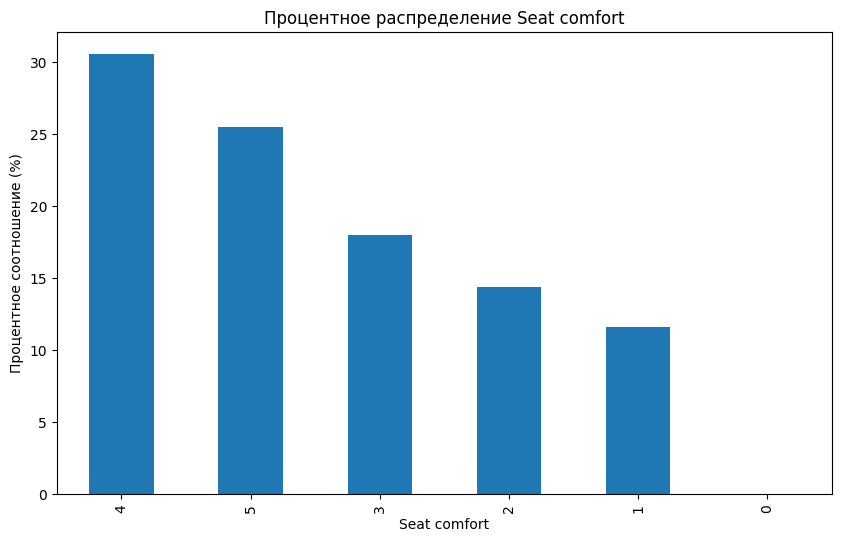

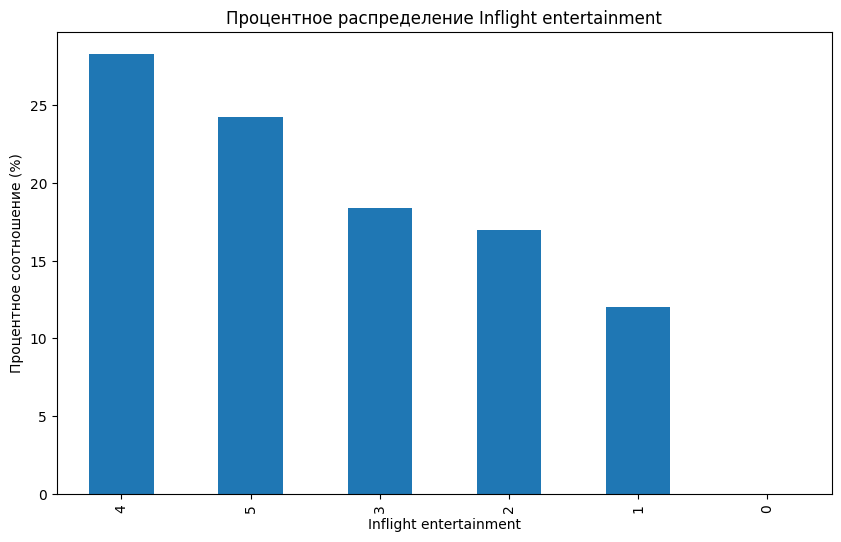

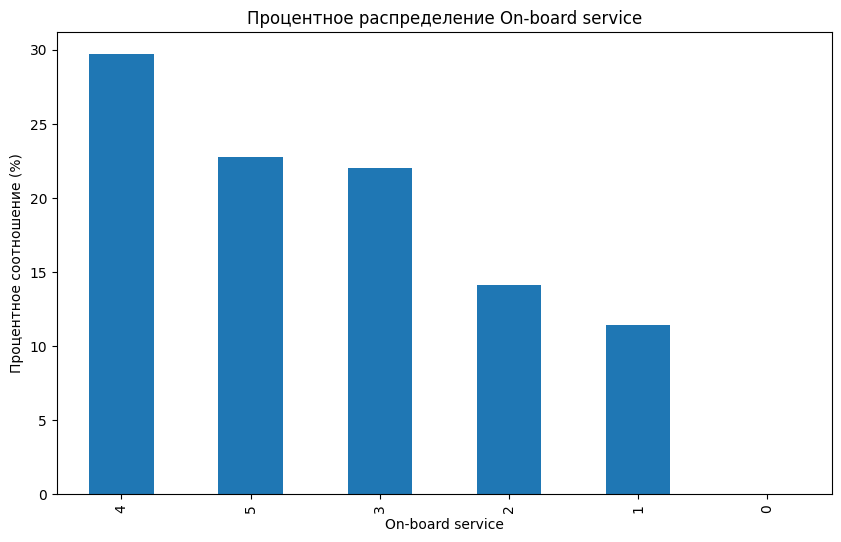

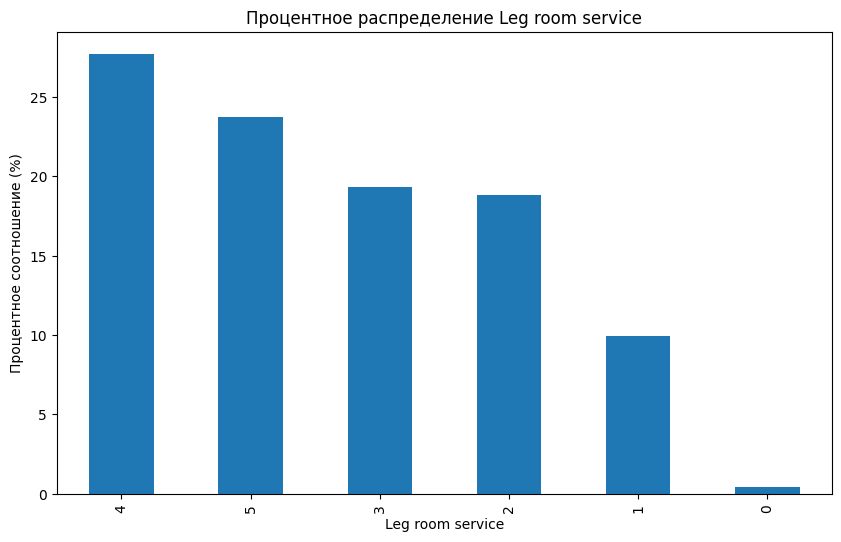

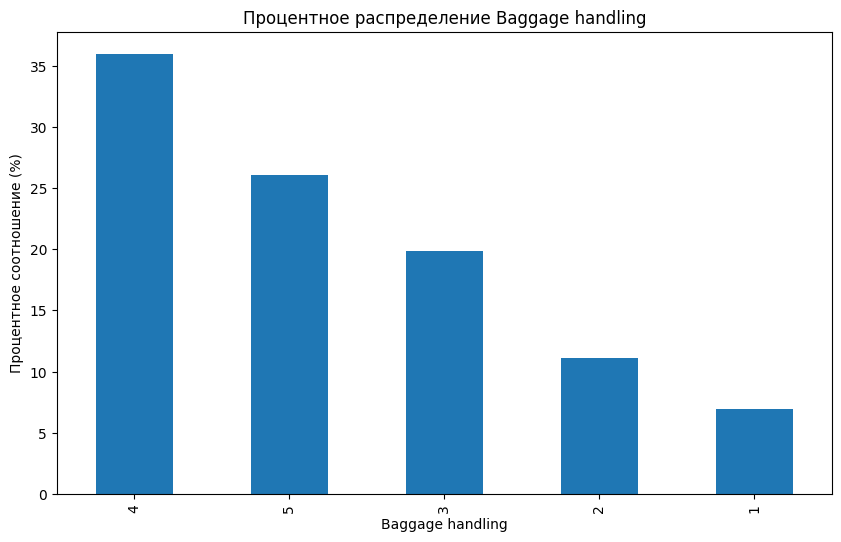

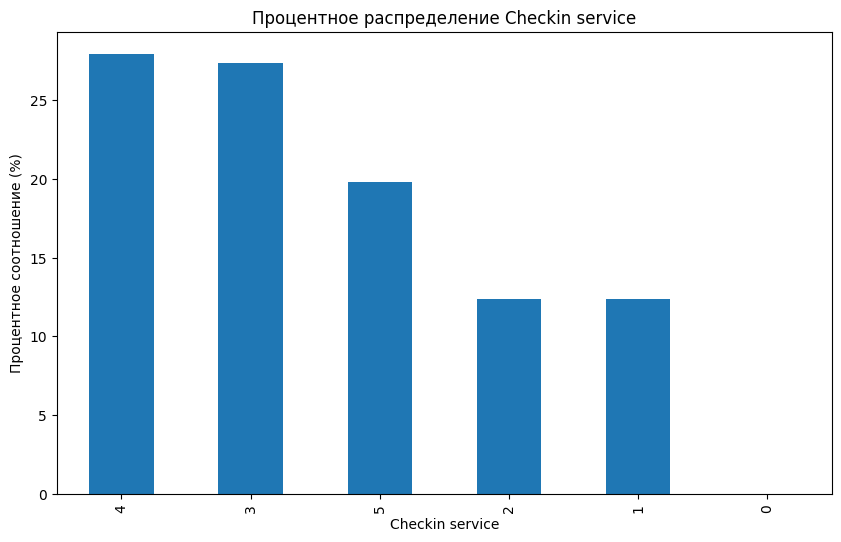

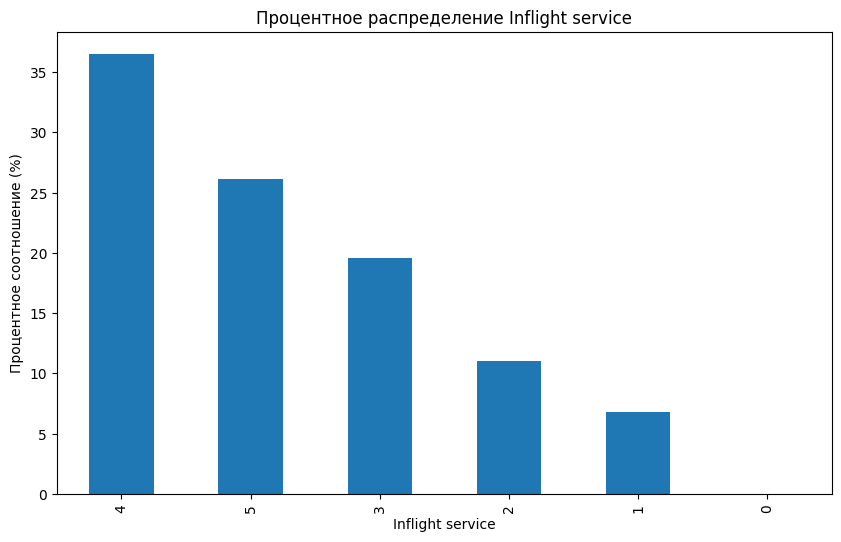

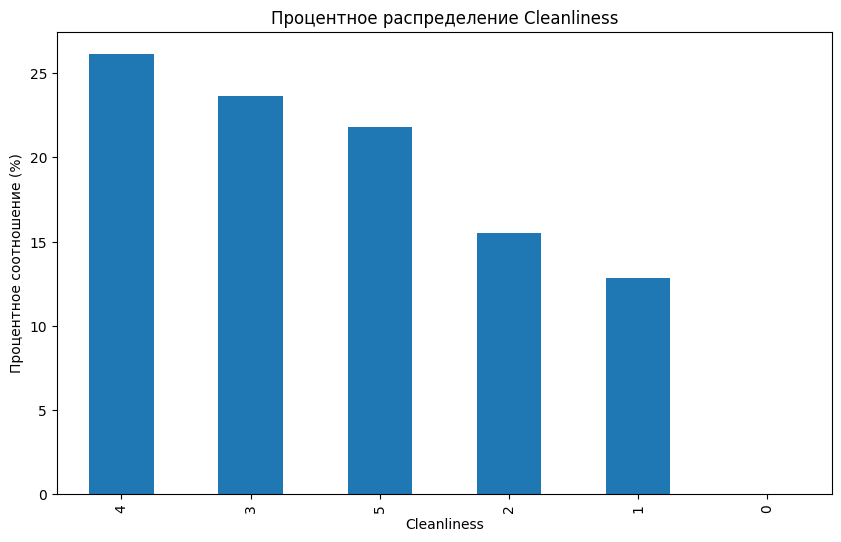

In [61]:
#Посмотрим на распределение оценок качества полета

plot_percent_data(df, 'Inflight wifi service')
plot_percent_data(df, 'Departure/Arrival time convenient')
plot_percent_data(df, 'Ease of Online booking')
plot_percent_data(df, 'Gate location')
plot_percent_data(df, 'Food and drink')
plot_percent_data(df, 'Online boarding')
plot_percent_data(df, 'Seat comfort')
plot_percent_data(df, 'Inflight entertainment')
plot_percent_data(df, 'On-board service')
plot_percent_data(df, 'Leg room service')
plot_percent_data(df, 'Baggage handling')
plot_percent_data(df, 'Checkin service')
plot_percent_data(df, 'Inflight service')
plot_percent_data(df, 'Cleanliness')

In [50]:
#Выводы об оценках:
#Самая популярная оценка обслцуживания - 4
#Хуже всего пассажиры оценили wifi в полете. Около 50% оценок 2 и 3
#Лучше всего пассадиры оценили комфорт сидений - 25% оценок 5

In [62]:
#Функция для сопоставления целевой переменной категориальной переменной
def plot_categorical_vs_target(df, target_column, category_column):
    crosstab_table = pd.crosstab(df[category_column], df[target_column])
    total_rows = crosstab_table.sum(axis=1)
    crosstab_df = crosstab_table.div(total_rows, axis=0) * 100
    crosstab_df.plot.bar(stacked=True, figsize=(8, 6), color=['black', 'red'])
    plt.xticks(rotation=45)
    plt.xlabel(category_column.capitalize())
    plt.ylabel('Percentage (%)')
    plt.show()

#Функция для сопоставления целевой переменной числовой переменной
def plot_numeric_vs_target(data, numeric_column, target_column):
    if numeric_column not in data.columns or target_column not in data.columns:
        raise ValueError("Указанные столбцы не найдены в DataFrame.")
    palette = 'dark:#5A9_r'
    sns.histplot(data=data, x=numeric_column, hue=target_column, multiple="stack", palette=palette, bins=20)
    plt.title(f'Гистограмма {numeric_column} по категориям {target_column}')
    plt.show()

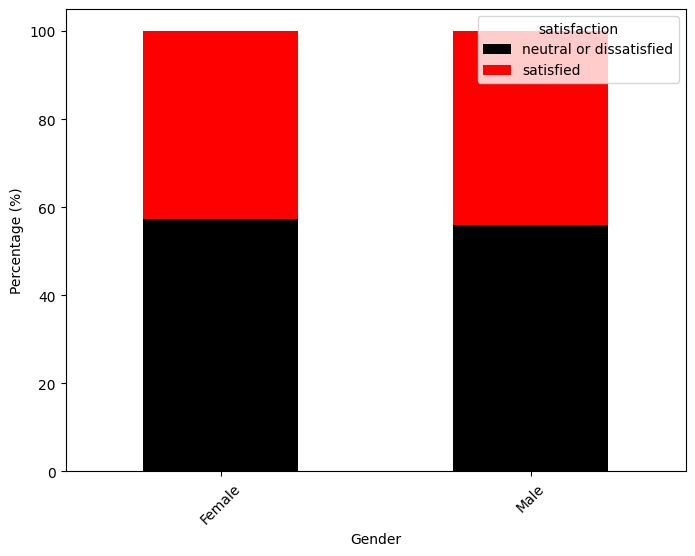

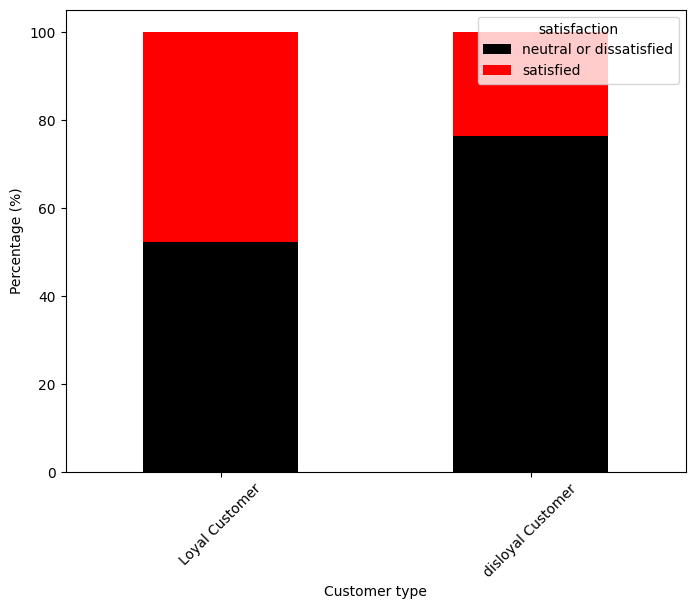

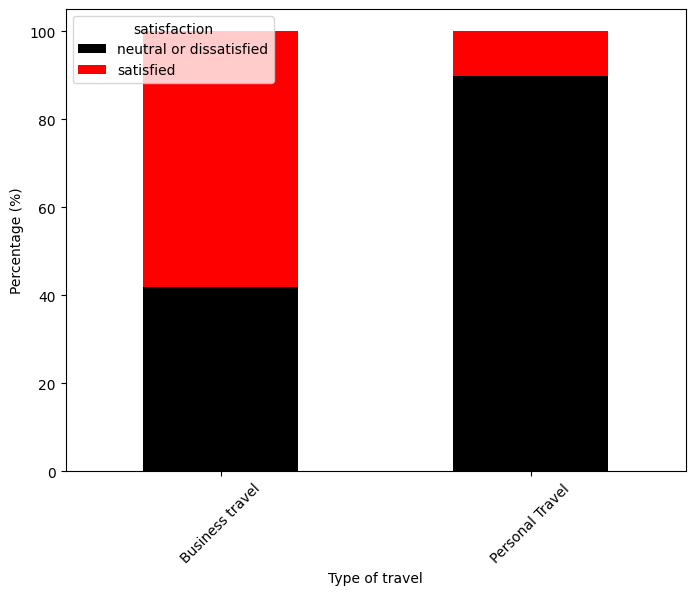

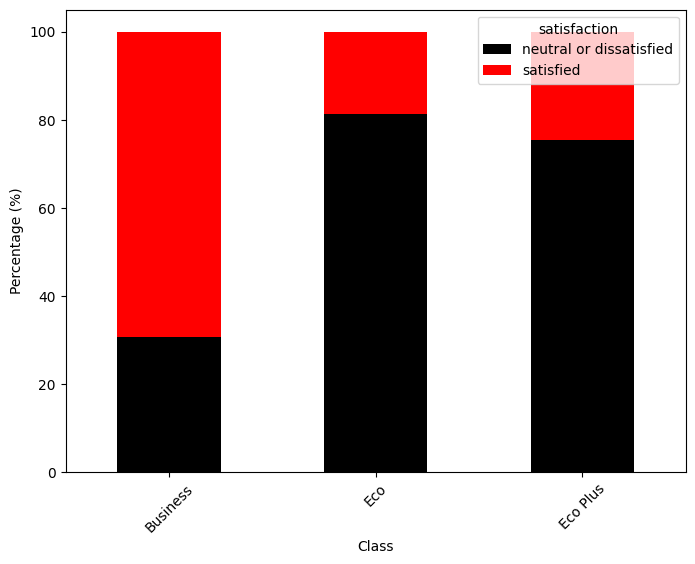

In [63]:
#Посмотрим на сопоставление целевой переменной категориальным переменным
plot_categorical_vs_target(df, 'satisfaction', 'Gender')
plot_categorical_vs_target(df, 'satisfaction', 'Customer Type')
plot_categorical_vs_target(df, 'satisfaction', 'Type of Travel')
plot_categorical_vs_target(df, 'satisfaction', 'Class')

In [53]:
#Выводы об удовлетворенности по категориальным данным:
#57% и 56% мужчин были недовольны полетом 
#Больше всего недовольных полетом среди нелояльных пассажиров - 76%, у лояльных - 52%
#70% пассажиров, летящих бизнесс-классом были довольны полетом
#81% пассажиров в эконом-классе недовольны полетом
#Около 60% летящих по деловым причинам были довольны полетом 
#90% летящих по личным причинам были недовольны

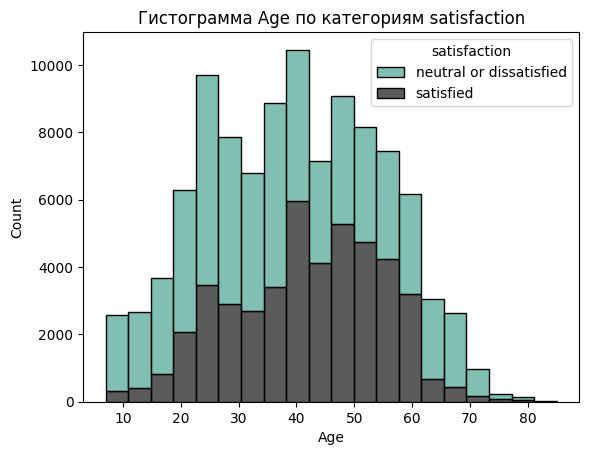

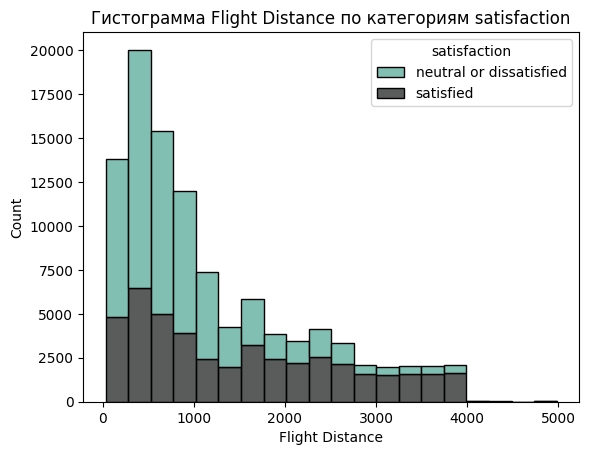

In [54]:
plot_numeric_vs_target(df, 'Age', 'satisfaction')
plot_numeric_vs_target(df, 'Flight Distance', 'satisfaction')

In [55]:
#Выводы об удовлетворенности по числовым данным:
#Среди пассажиров от 20 до 40 лет больше недовольных
#Среди пассажиров от 40 до 60 больше довольных
#Чем больше дальность полета, тем больше довольных пассажиров

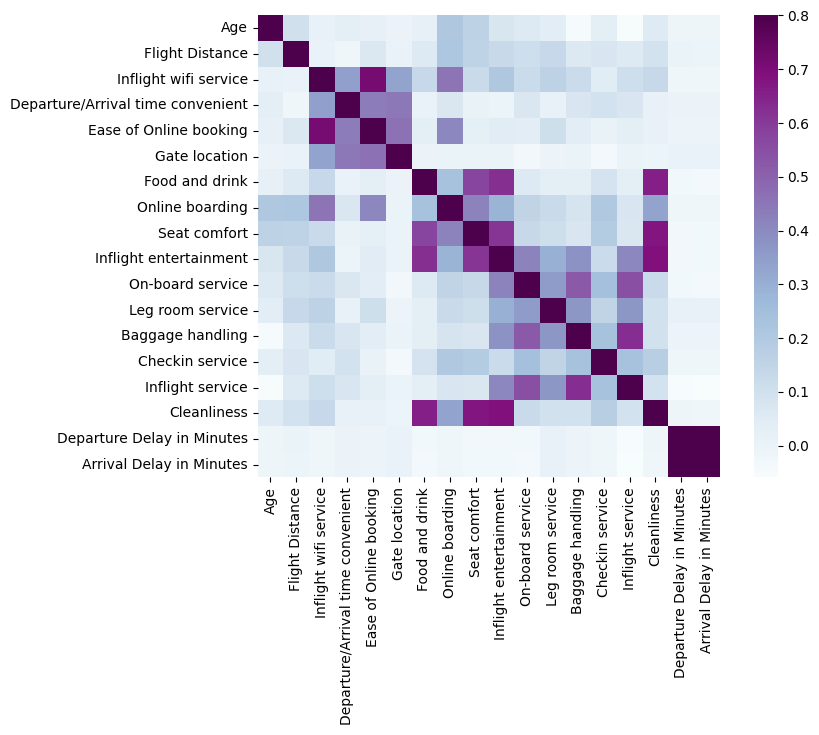

In [78]:
#Построим матрицу корреляции

numerical_columns = [col for col in df.columns if df[col].dtype != object]# Удаление категориальных столбцов
matrix = df[numerical_columns].corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu")
plt.show()


In [ ]:
#Выводы о матрице корреляции:
#Самые высокие значения у "Ease of Online booking" и "Inflight wifi service" - 0.7, то есть связь между удобством бронирования и доступностью Wi-Fi на борту
#Также есть связь между задержкой вылета и задержкой прибытия
#Остальные переменные, связанные с облуживанием на борту, имеют между собой связь, но не такую сильную

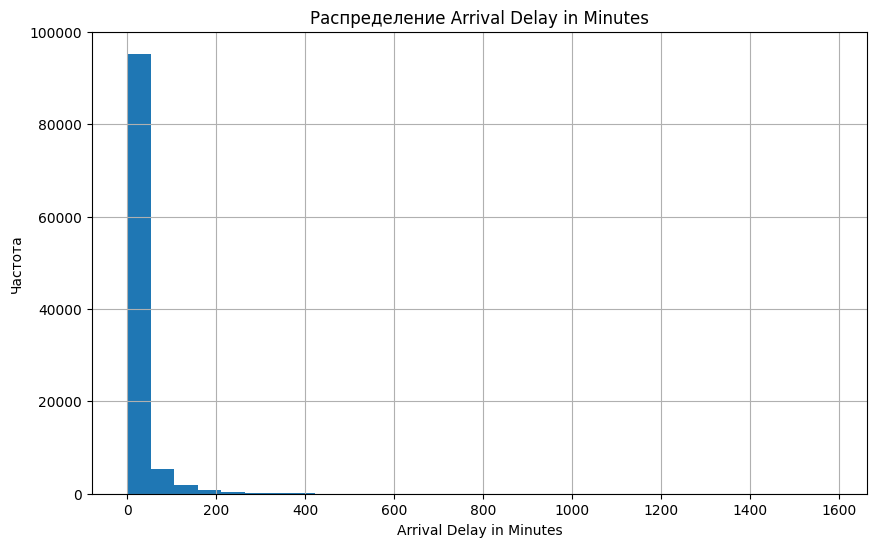

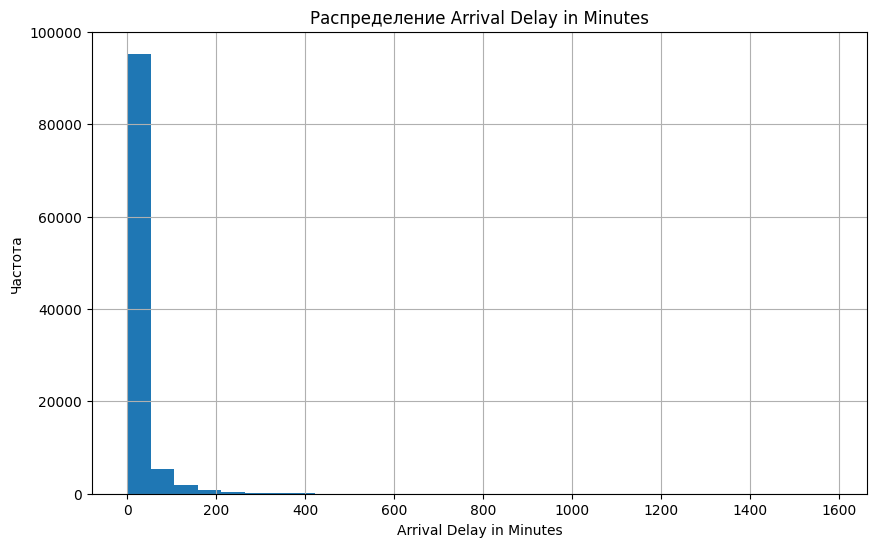

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [77]:
#Анализ данных проведен, теперь приступим к заполнению пустых данных и поиску выбросов
#Как мы выяснили ранее, пустые значения есть только в одном столбце - Arrival Delay in Minutes. Заполним их медианными значениями данного стообца
#И сравним, как на данные повлияли изменения
plot_numerical_data(df, 'Arrival Delay in Minutes') #График до изменений
median_arrival_delay = df['Arrival Delay in Minutes'].median()
df['Arrival Delay in Minutes'].fillna(median_arrival_delay, inplace=True)
plot_numerical_data(df, 'Arrival Delay in Minutes')  #График после изменений
df.isnull().sum()

In [ ]:
#Выводы о заполнении пустых данных:
#Все данные заполнены
#График распределения после заполнения ячеек не изменился

In [ ]:
#Теперь поищем выбросы